We need to make a file with all pairwise combinations to get our predictions. We also need to be able to turn this into a matrix later.

In [3]:
def read_phenotypes(filename):
    filepath = "" + filename
    with open(filepath, "r") as file:
        phenotypes = [line.rstrip("\n") for line in file]
    return phenotypes


TCRs = read_phenotypes("real_sample_TCRs.txt")
peptides = read_phenotypes("real_sample_peptides.txt")

In [4]:
import numpy as np

pairs = [[(TCR, pep) for TCR in TCRs] for pep in peptides]

In [5]:
missing = "<MIS>"

def get_row_dict_from_pair(pair):
    row_dict = {}
    row_dict["CDR3b"] = pair[0]
    row_dict["CDR3a"] = missing
    row_dict["peptide"] = pair[1]
    row_dict["MHC"] = missing
    row_dict["binder"] = 1

    return row_dict


In [6]:
import pandas as pd

row_list = []
for blom in pairs:
    for pair in blom:
        row_dict = get_row_dict_from_pair(pair)
        row_list.append(row_dict)

input = pd.DataFrame(row_list)
# input = pd.DataFrame(columns=["CDR3b","CDR3a","peptide","MHC","binder"])
input.to_csv("../data/input_5.csv")


### Now that the predictor has been run, let us create our simulation input: the binding probability matrix

In [7]:

def hist(data, log=False):
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = (10, 8)
    plt.rcParams["font.size"] = 25
    plt.rcParams["lines.linewidth"] = 4
    plt.rcParams["xtick.labelbottom"] = True

    plt.hist(data, log=log)
    plt.xlabel("", labelpad=20)
    plt.ylabel("", labelpad=20)

    return plt

252


Text(0.5, 1.0, 'Distribution of unscaled probabilities output by TULIP')

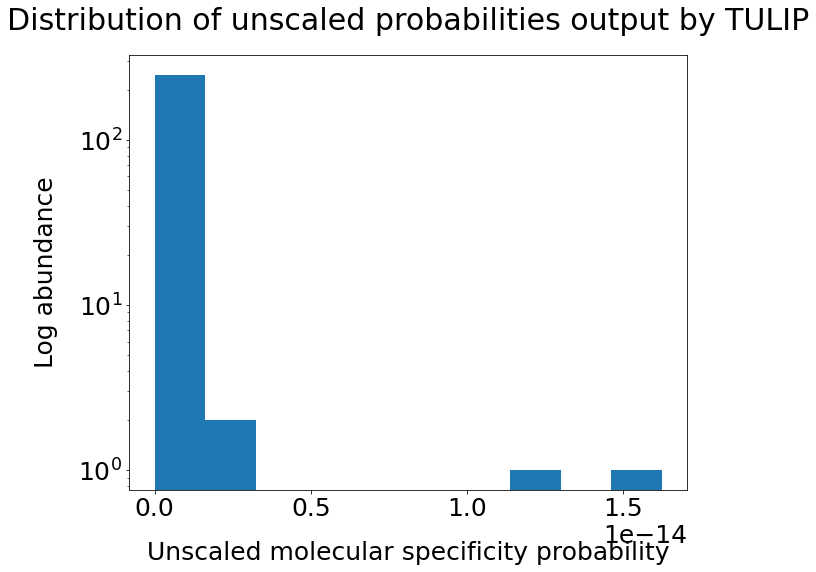

In [16]:
import pandas as pd
import numpy as np
from plotting import get_unique_output
import scipy.constants as sp

output = pd.read_csv("../output/" + get_unique_output("5"))
tulip_unscaled_probs = np.exp(output["score"])

import matplotlib.pyplot as plt

from binding_affinity_derivation import fit_params_and_get_pbind_from_tulip_probs

kplus = 21.4
kminus = 0.015
# avogadro = sp.Avogadro
# T_conc = np.power(np.int64(10), 14) 
# T_conc = T_conc / avogadro
# T_conc = (T_conc * np.power(10, 3)) 
# T_conc = T_conc * np.power(10, 6)
# print(T_conc)
# tulip_unscaled_probs = 10000000000000 * tulip_unscaled_probs
# tulip_unscaled_probs = [prob for prob in tulip_unscaled_probs if prob > 0.0001]

# T_conc = 0.5

print(len(tulip_unscaled_probs))

plt = hist(tulip_unscaled_probs, log=True)
plt.xlabel("Unscaled molecular specificity probability")
plt.ylabel("Log abundance")
plt.title("Distribution of unscaled probabilities output by TULIP", pad=25)

Text(0.5, 1.0, 'Distribution of probabilities derived from TULIP')

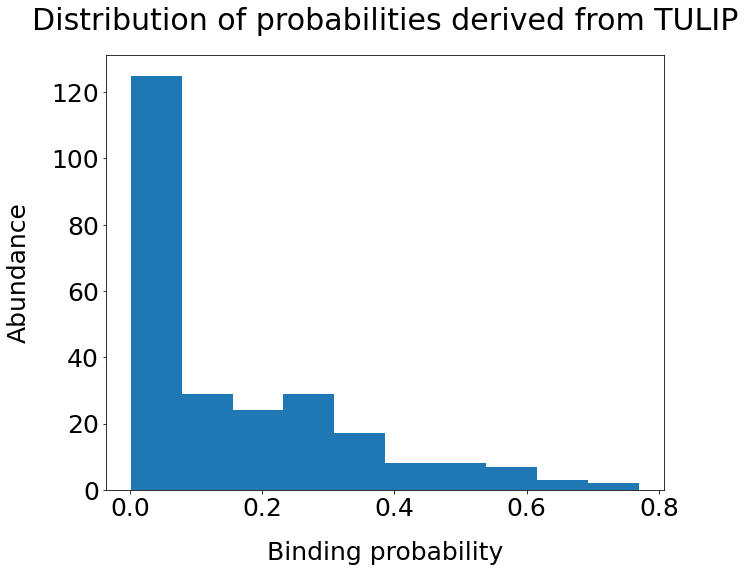

In [9]:
pbinds = fit_params_and_get_pbind_from_tulip_probs(tulip_unscaled_probs, kplus, kminus, 0.05)
plt = hist(pbinds)
plt.xlabel("Binding probability")
plt.ylabel("Abundance")
plt.title("Distribution of probabilities derived from TULIP", pad=25)

### We have our pbinds, so now we want to associate it with each pair

In [10]:
output

,receptor_number,CDR3a,CDR3b,peptide,score,rank,binder
0,0,<MIS>,CASSLHWGLSEKLFF,LGSPGDAGL,-39.831116,8,1
1,1,<MIS>,CASGTGENTEAFF,LGSPGDAGL,-38.708435,14,1
2,2,<MIS>,CASSLGTYGYTF,LGSPGDAGL,-36.843071,20,1
3,3,<MIS>,CATSDSRQGDASGELFF,LGSPGDAGL,-43.121780,1,1
4,4,<MIS>,CASFGSNQPQHF,LGSPGDAGL,-38.331421,16,1
...,...,...,...,...,...,...,...
247,16,<MIS>,CASRFPGTGGAGDPYEQYF,DYSHYYTSI,-38.384422,13,1
248,17,<MIS>,CASSMTGGGYNEQFF,DYSHYYTSI,-37.996445,16,1
249,18,<MIS>,CATSGPNALAGKQFF,DYSHYYTSI,-38.957169,10,1
250,19,<MIS>,CASSLAKLAGGRNTEAFF,DYSHYYTSI,-38.081192,14,1


Order gets preserved, which is reassuring. So we will use the arrays we have to index the matrix we want to make

In [11]:
P = len(peptides)
T = len(TCRs)
print(P, " ", T)

binding_prob_matrix = np.zeros((T, P))

12   21


In [12]:
for i in range(T):
    binding_prob_matrix[i] = pbinds[i * P: (i+1) * P]

We have now created our matrix.

In [13]:
binding_prob_matrix

array([[0.24015867, 0.30481243, 0.43030022, 0.10801068, 0.3285911 ,
        0.22135837, 0.25891572, 0.30746149, 0.23256654, 0.25249296,
        0.20116413, 0.38707985],
       [0.17538068, 0.06552412, 0.27652473, 0.36079412, 0.29858219,
        0.13435906, 0.21558176, 0.28830344, 0.38681364, 0.01192502,
        0.00951709, 0.00715459],
       [0.01112393, 0.00942249, 0.00897971, 0.01510773, 0.00882997,
        0.00940673, 0.01223983, 0.011871  , 0.00711581, 0.01133248,
        0.00425214, 0.00357084],
       [0.01320154, 0.01343048, 0.00625137, 0.00576681, 0.00961927,
        0.00668253, 0.00995166, 0.0164176 , 0.01823764, 0.00693111,
        0.0064366 , 0.03336839],
       [0.04199477, 0.00621082, 0.00943564, 0.01234027, 0.03447537,
        0.01435361, 0.00386186, 0.01749683, 0.01062794, 0.02548386,
        0.03261038, 0.01009199],
       [0.0154773 , 0.03531657, 0.01142606, 0.17460641, 0.21413033,
        0.24997478, 0.10876122, 0.09165521, 0.20298002, 0.16200965,
        0.05976635,

We now wish to export this!

In [14]:
np.size(binding_prob_matrix,1)

12

In [15]:
np.savetxt("matrix.txt", binding_prob_matrix)